In [30]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
SEED_CONSTANT= 42
np.random.seed(SEED_CONSTANT)
tf.random.set_seed(SEED_CONSTANT)

DATASET_DIR = '/content/drive/MyDrive/Colab Notebooks/UCF50'
SELECTED_ACTIONS = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

VIDEO_WIDTH= 64 # All video have same width of 320
VIDEO_HEIGHT= 64 # All video have same height of 240
MAX_FRAMES= 20 # Maximum of 30 frames from each video

In [5]:
allActions= os.listdir(DATASET_DIR)
print(allActions)

['Diving', 'Biking', 'CleanAndJerk', 'Fencing', 'BaseballPitch', 'Billiards', 'Drumming', 'BreastStroke', 'BenchPress', 'Basketball', 'GolfSwing', 'HighJump', 'HorseRace', 'HorseRiding', 'JavelinThrow', 'HulaHoop', 'JugglingBalls', 'JumpingJack', 'JumpRope', 'Kayaking', 'Lunges', 'MilitaryParade', 'Mixing', 'Nunchucks', 'PizzaTossing', 'PlayingGuitar', 'PlayingPiano', 'PlayingTabla', 'PlayingViolin', 'PoleVault', 'PommelHorse', 'Punch', 'PushUps', 'PullUps', 'RockClimbingIndoor', 'RopeClimbing', 'Rowing', 'SalsaSpin', 'SkateBoarding', 'Skiing', 'Skijet', 'SoccerJuggling', 'Swing', 'TaiChi', 'TennisSwing', 'ThrowDiscus', 'TrampolineJumping', 'VolleyballSpiking', 'YoYo', 'WalkingWithDog']


WalkingWithDog = 123
Minimum video resolution 240.0x320.0
Maximum video resolution 240.0x320.0
Minimum video duration 3.1031
Maximum video duration 8.008000000000001

TaiChi = 100
Minimum video resolution 240.0x320.0
Maximum video resolution 240.0x320.0
Minimum video duration 6.72
Maximum video duration 10.68

Swing = 137
Minimum video resolution 240.0x320.0
Maximum video resolution 240.0x320.0
Minimum video duration 2.04
Maximum video duration 13.4

HorseRace = 147
Minimum video resolution 240.0x320.0
Maximum video resolution 240.0x320.0
Minimum video duration 2.6026000000000002
Maximum video duration 13.046366666666668



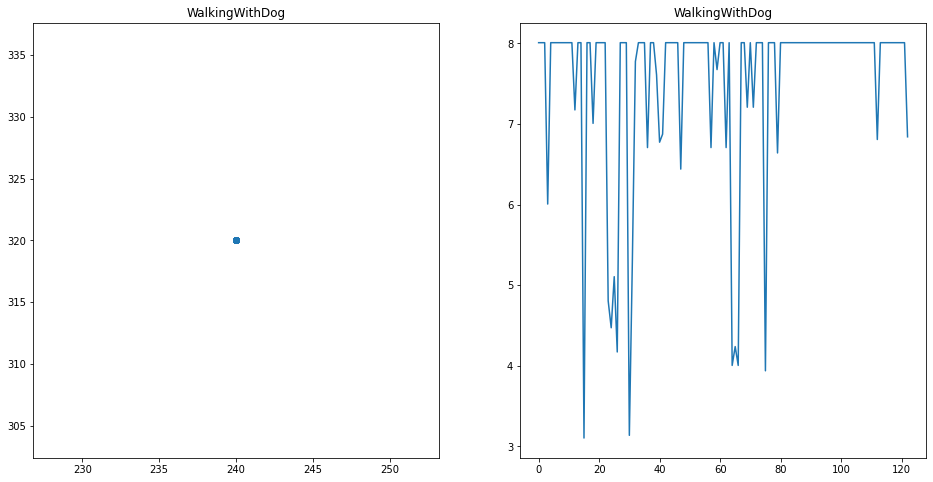

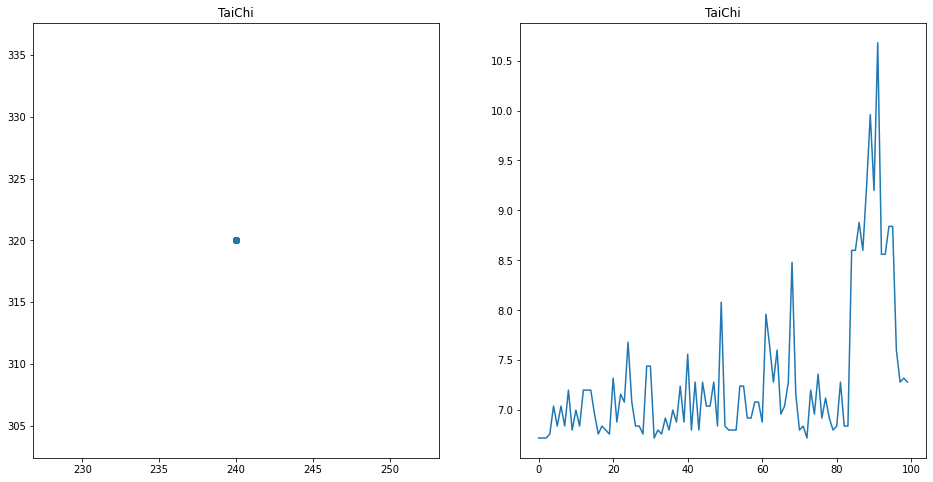

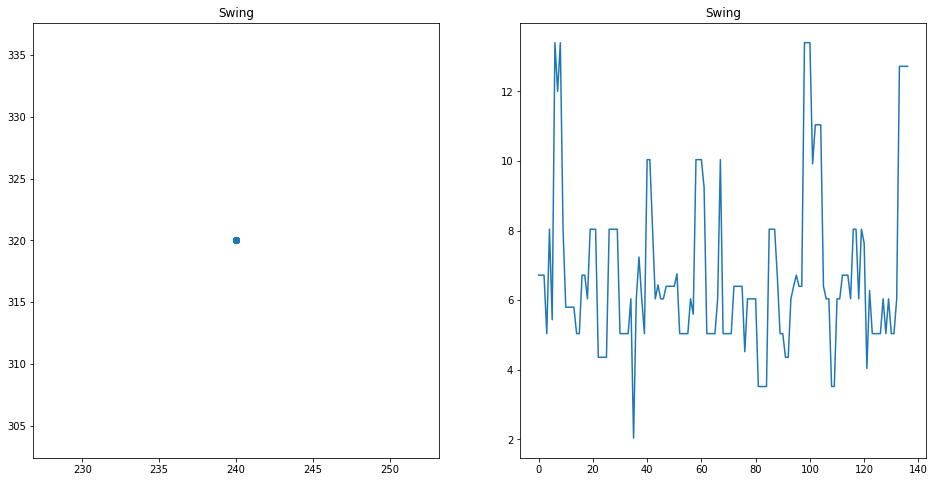

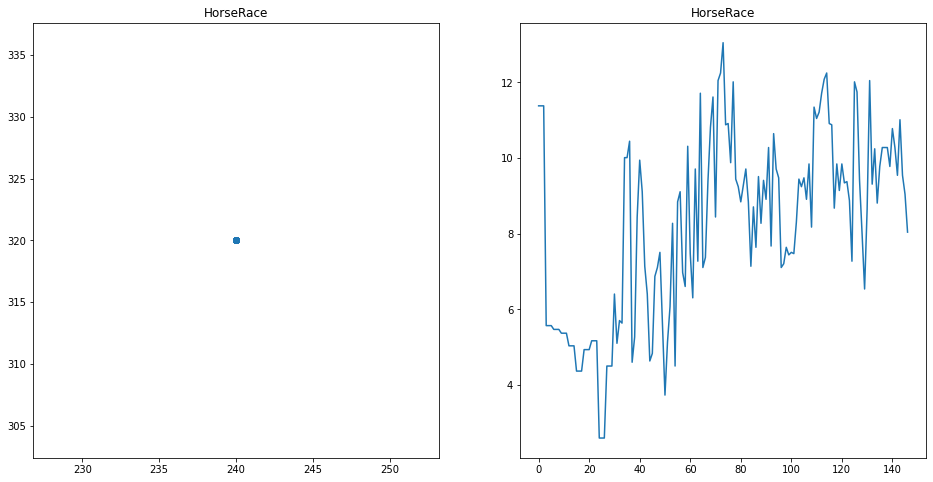

In [ ]:
for currentAction in SELECTED_ACTIONS:
    videos = os.listdir(f'{DATASET_DIR}/{currentAction}')
    
    videoWidths= []
    videoHeights= []
    videoDurations= []
    # videoFPS= [] all videos are 30 FPS
    for vid in videos:
        cap = cv2.VideoCapture(f'{DATASET_DIR}/{currentAction}/{vid}')
        videoWidths.append(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        videoHeights.append(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        videoDurations.append(cap.get(cv2.CAP_PROP_FRAME_COUNT)/cap.get(cv2.CAP_PROP_FPS))
        # videoFPS.append(cap.get(cv2.CAP_PROP_FPS))
        cap.release()
    
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    plt.scatter(videoHeights, videoWidths)
    plt.title(currentAction)
    plt.subplot(122)
    plt.plot(videoDurations)
    plt.title(currentAction)

    print(currentAction, f'= {len(videoDurations)}')
    print(f'Minimum video resolution {min(videoHeights)}x{min(videoWidths)}')
    print(f'Maximum video resolution {max(videoHeights)}x{max(videoWidths)}')
    print(f'Minimum video duration {min(videoDurations)}')
    print(f'Maximum video duration {max(videoDurations)}', end='\n\n')

In [6]:
def frameExtraction(videoPath):
    frames= []
    cap= cv2.VideoCapture(videoPath)

    frameCount= int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameSkipInterval= max(int(frameCount/MAX_FRAMES), 1)

    for count in range(MAX_FRAMES):
        cap.set(cv2.CAP_PROP_POS_FRAMES, count*frameSkipInterval)
        success, frame = cap.read()
        
        if not success:
            break

        resizedFrame= cv2.resize(frame, (VIDEO_HEIGHT, VIDEO_WIDTH))
        # To normalize the RGB values of each pixel between 0-1
        normalizedFrame= resizedFrame/255
        frames.append(normalizedFrame)

    cap.release()
    return frames

In [7]:
def createDataset():
    features= []
    labels= []

    for action in SELECTED_ACTIONS:
        print(f'Extracting data of action: {action}')
        videoDir= os.listdir(os.path.join(DATASET_DIR, action))

        for video in videoDir:
            filePath= os.path.join(DATASET_DIR, action, video)
            frames= frameExtraction(filePath)

            if len(frames) == MAX_FRAMES:
                features.append(frames)
                labels.append(action)
    
    features= np.asarray(features)
    labels= np.array(labels)

    return features, labels

In [18]:
features, labels= createDataset()

Extracting data of action: WalkingWithDog
Extracting data of action: TaiChi
Extracting data of action: Swing
Extracting data of action: HorseRace


In [19]:
oneHotLabels= OneHotEncoder(sparse=False).fit_transform(labels.reshape(-1, 1))
print(oneHotLabels)

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [20]:
X_train, X_test, y_train, y_test= train_test_split(features, oneHotLabels, test_size=0.25, shuffle=True, random_state=SEED_CONSTANT)

In [21]:
print(np.shape(features))
print(np.shape(X_train))
print(np.shape(y_train))

(507, 20, 64, 64, 3)
(380, 20, 64, 64, 3)
(380, 4)


In [22]:
def plotMetric(model_training_history, metric1, metric2, plot_name):
  metric1_value= model_training_history.history[metric1]
  metric2_value= model_training_history.history[metric2]

  epochs= range(len(metric1_value))

  plt.plot(epochs, metric1_value, 'blue', label=metric1)
  plt.plot(epochs, metric2_value, 'red', label=metric2)

  plt.title(plot_name)
  plt.legend()

earlyStoppingCallback= EarlyStopping(monitor='val_accuracy', patience= 15, mode='max', restore_best_weights=True)
earlyStoppingCallback2= EarlyStopping(monitor='val_loss', patience= 8, mode='min', restore_best_weights=True)
reduceLRCallback= ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, mode='min')

In [23]:
def createLRCN():

    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(16, 3, padding='same',activation = 'relu'),
                              input_shape = (MAX_FRAMES, VIDEO_WIDTH, VIDEO_HEIGHT, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, 3, padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, 3, padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, 3, padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    # model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(SELECTED_ACTIONS), activation = 'softmax'))
 
    model.summary()
    return model

In [24]:
lrcn_model= createLRCN()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 20, 64, 64, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 20, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 20, 16, 16, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 20, 4, 4, 32)    

In [25]:
lrcn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

lrcn_model_training = lrcn_model.fit(x = X_train, y = y_train, epochs = 70, batch_size = 4, shuffle = True, validation_split = 0.2, callbacks=[earlyStoppingCallback])

Epoch 1/70
76/76 [==============================] - 3s 17ms/step - loss: 1.3864 - accuracy: 0.2730 - val_loss: 1.3640 - val_accuracy: 0.3158
Epoch 2/70
76/76 [==============================] - 1s 10ms/step - loss: 1.3629 - accuracy: 0.3224 - val_loss: 1.2983 - val_accuracy: 0.5395
Epoch 3/70
76/76 [==============================] - 1s 9ms/step - loss: 1.2456 - accuracy: 0.4375 - val_loss: 1.1647 - val_accuracy: 0.4868
Epoch 4/70
76/76 [==============================] - 1s 10ms/step - loss: 1.0938 - accuracy: 0.5099 - val_loss: 1.0637 - val_accuracy: 0.5921
Epoch 5/70
76/76 [==============================] - 1s 9ms/step - loss: 0.9225 - accuracy: 0.6020 - val_loss: 0.9980 - val_accuracy: 0.5789
Epoch 6/70
76/76 [==============================] - 1s 10ms/step - loss: 0.8070 - accuracy: 0.6579 - val_loss: 0.6682 - val_accuracy: 0.7632
Epoch 7/70
76/76 [==============================] - 1s 9ms/step - loss: 0.7825 - accuracy: 0.6743 - val_loss: 0.7957 - val_accuracy: 0.6579
Epoch 8/70
76/76

In [26]:
model_loss, model_accuracy= lrcn_model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 87ms/step - loss: 0.4575 - accuracy: 0.8976


In [27]:
lrcn_model.evaluate(features, oneHotLabels)

16/16 [==============================] - 1s 40ms/step - loss: 0.1535 - accuracy: 0.9645


[0.15348705649375916, 0.9644970297813416]

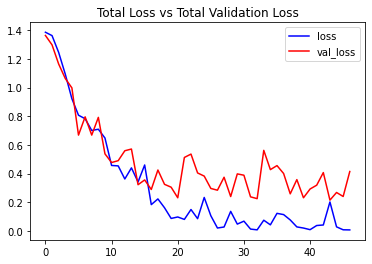

In [28]:
plotMetric(lrcn_model_training, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

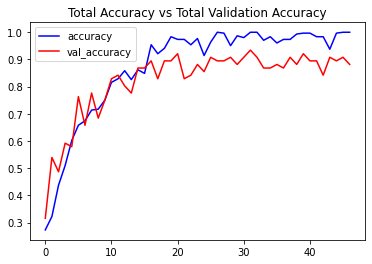

In [29]:
plotMetric(lrcn_model_training, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [37]:
y_pred= lrcn_model.predict(X_test)
y_pred= np.argmax(y_pred, axis=1)
y_test_single_row= np.argmax(y_test, axis=1)
score= f1_score(y_test_single_row, y_pred, average=None)

print(score)
print(SELECTED_ACTIONS)

[0.94505495 0.92063492 0.87179487 0.81967213]
['WalkingWithDog', 'TaiChi', 'Swing', 'HorseRace']
